In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt
%matplotlib inline
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

### Классификация. Анализ стоит ли давать кредит человеку основываясь на параметрах.

In [2]:
data = pd.read_csv("customer_data.csv")
data.shape

(1125, 13)

### Препроцессинг данных

In [3]:
del data['id']

In [4]:
data.columns

Index(['label', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7',
       'fea_8', 'fea_9', 'fea_10', 'fea_11'],
      dtype='object')

In [5]:
mean = data['fea_2'].mean()
std = data['fea_2'].std() # стандартное отклонение
number_of_nulls = data['fea_2'].isnull().sum()
random_v = np.random.randint(mean - std, mean + std, size=number_of_nulls)

In [6]:
new_v = data['fea_2'].copy()
new_v[np.isnan(new_v)] = random_v
data['fea_2'] = new_v

In [7]:
data.head()

,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,7,1325.0,2,59000.0,2,11,5,108,4,450081,197.403141


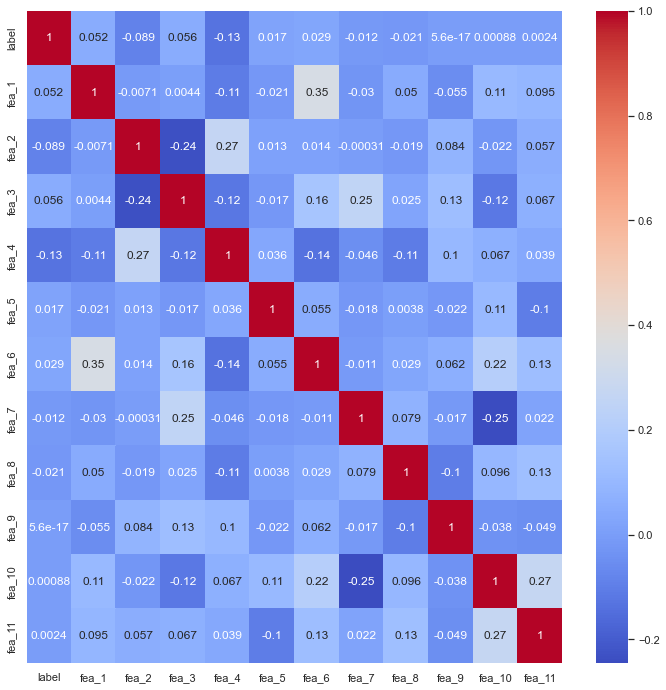

In [8]:
figure = plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
None

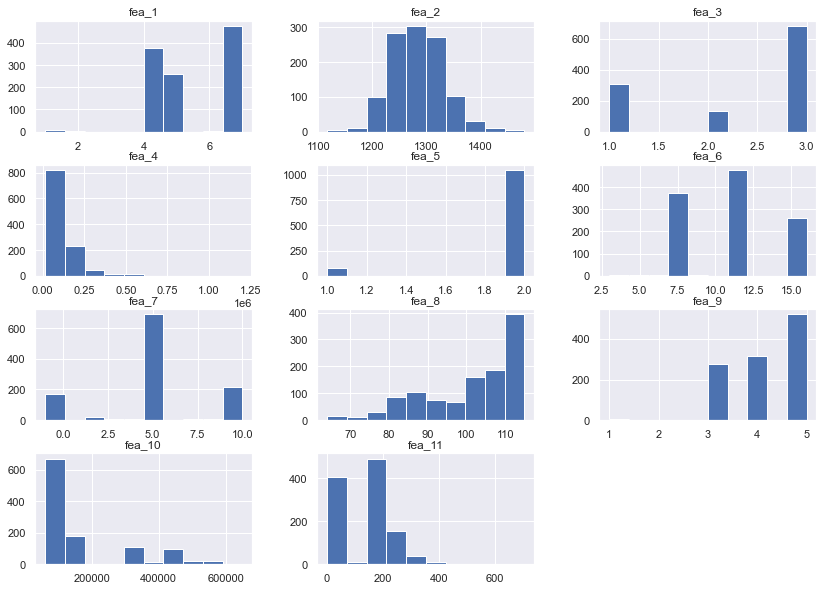

In [9]:
data.hist(column=data.columns[1:12], figsize=(14, 10))
None

### Реализация метрики качества. \\ аргументировать выбор метрики качества 

Так как у нас всего два класса, используем оценки качества precision и recall, но нам надо обьеденить их в одну, поэтому используем новое выражение называемое F-мерой, который считается как 
```(1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)```

In [10]:
def F(x, y, betta=1):
    TP = sum([x[i] == 1 and y[i] == 1 for i in range(len(x))])
    FP = sum([x[i] == 1 and y[i] == 0 for i in range(len(x))])
    FN = sum([x[i] == 0 and y[i] == 1 for i in range(len(x))])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return (1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)

In [11]:
indicators = data.columns[1:12]
target_columns = data.columns[0]

In [12]:
X = data[indicators]
y = data[target_columns]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2)

### Реализация Standart Scaller

In [14]:
def scaller(data):
    data = data.transpose()
    for row in data:
        avg = sum([x for x in row]) / len(row)
        dist = sqrt(sum([(x-avg)**2 for x in row]) / len(row))
        for i in range(len(row)):
            row[i] = (row[i] - avg) / dist
    return data.transpose()

### Разбиение на обучающую и тестовую выборки

In [15]:
indicators = data.columns[1:12]
target_columns = data.columns[0]

In [16]:
X = data[indicators]
y = data[target_columns]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2)

In [18]:
X_scalled = scaller(X.to_numpy())

In [19]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_scalled, y, test_size=0.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((900, 11), (225, 11), (900,), (225,))

### Реализация и обучение логистической регрессии

In [21]:
class LR:
    def __init__(self, step=10**-2, it_c=100):
        self.step = step
        self.it_c = it_c

    def get_coeff(self, x, y):
        return self.err(x, y.values.ravel())
    
    def err(self, x, y):
        p = [self.predict(i) for i in x]
        return sum(p==y) / len(y)
    
    def reg(self):
        return 0
    
    def fit(self, x, y, X_valid=X_test, y_valid=y_test):
        y_valid = y_valid.values.ravel()
        y = y.values.ravel()
        np.c_[x, np.ones(len(x))]
        self.w = np.zeros(x.shape[1])
        f,h = [],[]
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad - self.reg()
            error = self.err(x, y)
            h.append(error)
            F_norm = F(self.predict(X_valid), y_valid)
            f.append(F_norm)
        return h, f
            
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()
    
    def F_mera(self, x, y):
        f(x,y)

### Добавление регуляризации

In [22]:
class LRreg(LR):
    def __init__(self, step=10**-2, it_c=400, L=None, alpha=0.00001):
        self.step = step
        self.it_c = it_c
        self.L = L
        self.alpha = alpha
        
    def reg(self):
        if self.L == 'L1':
            return self.alpha * sum([abs(i) for i in self.w])
        elif self.L == 'L2':
            return self.alpha * sum([i**2 for i in self.w])
        else:
            return 0

### Оценка качества модели на обучающей и тестовой выборках

In [23]:
itc = 450

In [24]:
mlg = LR(it_c=itc)
hist, f = mlg.fit(X_train, y_train)
print(f"\nmy LogReg: {mlg.get_coeff(X_test, y_test)}")


my LogReg: 0.2222222222222222


In [25]:
mlgL1 = LRreg(it_c=itc, L='L1')
histL1, fL1 = mlgL1.fit(X_train, y_train)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test, y_test)}")


my LogReg L1: 0.2222222222222222


In [26]:
mlgL2 = LRreg(it_c=itc, L='L2')
histL2, fL2 = mlgL2.fit(X_train, y_train)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test, y_test)}")


my LogReg L2: 0.0


### График точности моделей для всех регулязациях (без нее, L1, L2)

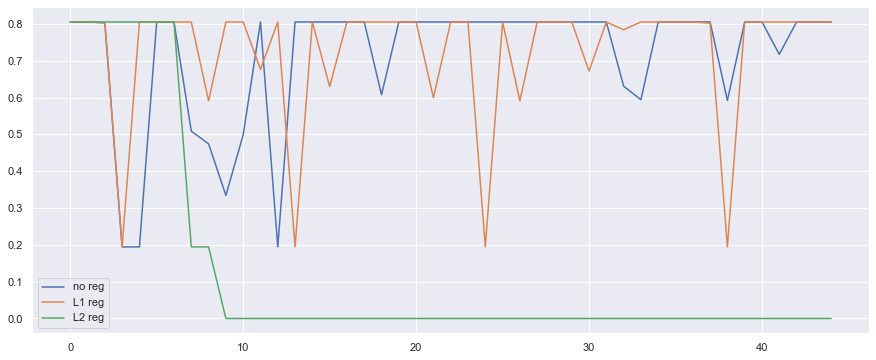

In [27]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist[::10], label="no reg")
plt.plot(histL1[::10], label="L1 reg")
plt.plot(histL2[::10], label="L2 reg")
plt.legend()
plt.show()

### График метрики моделей для всех регулязациях (без нее, L1, L2) чем больше тем лучше

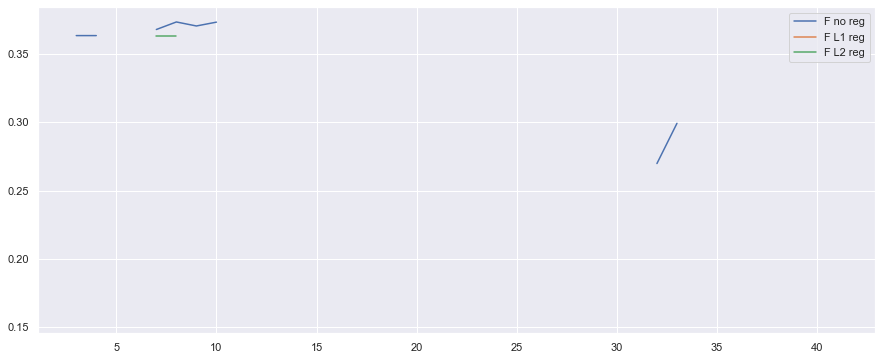

In [28]:
figure = plt.figure(figsize=(15,6))
plt.plot(f[::10], label="F no reg")
plt.plot(fL1[::10], label="F L1 reg")
plt.plot(fL2[::10], label="F L2 reg")
plt.legend()
plt.show()

### Оценка качества модели на обучающей и тестовой выборках которые прошли Scaller

In [29]:
mlg = LR(it_c=itc)
hist, f = mlg.fit(X_train_S, y_train_S, X_valid=X_test_S, y_valid=y_test_S)
print(f"my LogReg: {mlg.get_coeff(X_test_S, y_test_S)}")

my LogReg: 0.5644444444444444


In [30]:
mlgL1 = LRreg(it_c=itc, L='L1')
histL1, fL1 = mlgL1.fit(X_train_S, y_train_S, X_valid=X_test_S, y_valid=y_test_S)
print(f"my LogReg L1: {mlgL1.get_coeff(X_test_S, y_test_S)}")

my LogReg L1: 0.56


In [31]:
mlgL2 = LRreg(it_c=itc, L='L2')
histL2, fL2 = mlgL2.fit(X_train_S, y_train_S, X_valid=X_test_S, y_valid=y_test_S)
print(f"my LogReg L2: {mlgL2.get_coeff(X_test_S, y_test_S)}")

my LogReg L2: 0.5644444444444444


### Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на обучающей и тестовой выборках и сравнить со своей моделью

In [32]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=1400)
sklg.fit(X_train, y_train.values.ravel())
print(f"sklearn: {sklg.score(X_test, y_test.values.ravel())}")

sklearn: 0.7777777777777778


In [33]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=3000)
sklg.fit(X_train_S, y_train_S.values.ravel())
print(f"sklearn: {sklg.score(X_test_S, y_test_S.values.ravel())}")

sklearn: 0.7688888888888888


### Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
### Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

In [34]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(max_iter=1400), X_train, y_train.values.ravel(), cv=5)

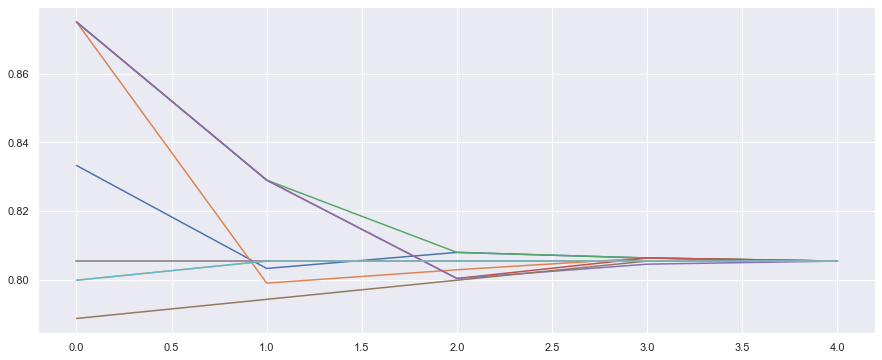

In [35]:
figure = plt.figure(figsize=(15,6))
plt.plot(train_scores)
plt.plot(valid_scores)
plt.show()

### Создадим функцию для поиска наилучших гиперпараметров

In [36]:
def GridSearch(step, it_c, L, alpha, Xy_train, Xy_test):
    bestF = 0
    best_estimators = {'step':None, 'it_c':None, 'L':None, 'alpha':None}
    best_model = None
    model,h,f = None, None, None
    for s in step:
        for it in it_c:
            for l in L:
                if l == 'L1':
                    for alp in alpha:
                        print(f"step:{s}, it_c:{it}, L:{l}, alpha:{alp}")
                        model = LRreg(step=s, it_c=it, L='L1', alpha=alp)
                        h,f = model.fit(Xy_train[0], Xy_train[1], X_valid=Xy_test[0], y_valid=Xy_test[1])
                        if f[-1] > bestF:
                            bestF=f[-1]
                            best_model=model
                            best_estimators={'step':s, 'it_c':it, 'L':l, 'alpha':alp}
                            print(bestF, best_estimators)
                elif l == 'L2':
                    for alp in alpha:
                        print(f"step:{s}, it_c:{it}, L:{l}, alpha:{alp}")
                        model = LRreg(step=s, it_c=it, L='L1', alpha=alp)
                        h,f = model.fit(Xy_train[0], Xy_train[1], X_valid=Xy_test[0], y_valid=Xy_test[1])
                        if f[-1] > bestF:
                            bestF=f[-1]
                            best_model=model
                            best_estimators={'step':s, 'it_c':it, 'L':l, 'alpha':alp}
                            print(bestF, best_estimators)
                else:
                    print(f"step:{s}, it_c:{it}, 'L':None, 'alpha':None")     
                    mlg = LR()
                    h,f = mlg.fit(Xy_train[0], Xy_train[1], X_valid=Xy_test[0], y_valid=Xy_test[1])
                    if f[-1] > bestF:
                        bestF=f[-1]
                        best_model=model
                        best_estimators={'step':s, 'it_c':it, 'L':None, 'alpha':None}
                        print(bestF, best_estimators)
                        
    return best_model, bestF, best_estimators

In [37]:
m, f, est = GridSearch([10**-2,10**-3,10**-1],
                       [200,220,240,500]
                       ['','L1','L2'],
                       [0.0001,0.00001],
                       [X_train_S, y_train_S],
                       [X_test_S, y_test_S])

step:0.01, it_c:100, 'L':None, 'alpha':None
0.40236686390532544 {'step': 0.01, 'it_c': 100, 'L': None, 'alpha': None}
step:0.01, it_c:100, L:L1, alpha:0.0001
step:0.01, it_c:100, L:L1, alpha:1e-05
0.40476190476190477 {'step': 0.01, 'it_c': 100, 'L': 'L1', 'alpha': 1e-05}
step:0.01, it_c:100, L:L2, alpha:0.0001
step:0.01, it_c:100, L:L2, alpha:1e-05
step:0.01, it_c:120, 'L':None, 'alpha':None
step:0.01, it_c:120, L:L1, alpha:0.0001
step:0.01, it_c:120, L:L1, alpha:1e-05
step:0.01, it_c:120, L:L2, alpha:0.0001
step:0.01, it_c:120, L:L2, alpha:1e-05
step:0.01, it_c:140, 'L':None, 'alpha':None
step:0.01, it_c:140, L:L1, alpha:0.0001
step:0.01, it_c:140, L:L1, alpha:1e-05
0.407185628742515 {'step': 0.01, 'it_c': 140, 'L': 'L1', 'alpha': 1e-05}
step:0.01, it_c:140, L:L2, alpha:0.0001
step:0.01, it_c:140, L:L2, alpha:1e-05
step:0.01, it_c:200, 'L':None, 'alpha':None
step:0.01, it_c:200, L:L1, alpha:0.0001
step:0.01, it_c:200, L:L1, alpha:1e-05
0.40963855421686746 {'step': 0.01, 'it_c': 200, '

In [38]:
f, est

(0.41860465116279066, {'step': 0.1, 'it_c': 100, 'L': 'L1', 'alpha': 0.0001})

### Обучим модель с данными параметрами

In [39]:
model = LRreg(L='L1', step=0.01, it_c=800, alpha=0.0001)
h, f = model.fit(X_train, y_train)
print(f"my best LogReg L1: {model.get_coeff(X_test, y_test)}")

my best LogReg L1: 0.7777777777777778


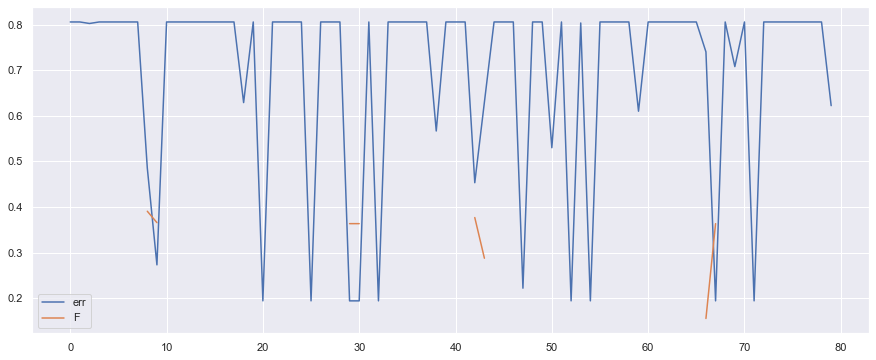

In [40]:
figure = plt.figure(figsize=(15,6))
plt.plot(h[::10], label="err")
plt.plot(f[::10], label="F")
plt.legend()
plt.show()